# Analiza podatkov o restavracijah s študentsko prehrano s Pandas

Analizirala sem podatke o restavracijah s študentsko prehrano po Sloveniji, pridobljenih na spletni strani [Študentska prehrana](https://www.studentska-prehrana.si/sl/restaurant). Zajela sem imena restavracij, njihove lokacije, ceno obroka in dodatne lastnosti, ki jih posamezna restavracija ponuja, kot so dostopnost za invalide, možnost dostave, primernost za vegetarijance ... Pomagala sem si tudi s statističnimi podatki s spletne strani [SiStat](https://pxweb.stat.si/SiStat) o številu turistov, ki so obiskali slovenske občine v letih 2018 in 2019. Zanimalo me je namreč, ali je cena obroka povezana z velikostjo ponudbe v določenem kraju, s turistično obiskanostjo kraja ali morda z dodatnimi lastnostmi restavracije. Prav tako me je zanimalo, ali so le te lastnosti odvisne od lokacije restavracije.

Postavila sem si štiri delovne hipoteze:
* V turistično bolj obiskanih krajih je cena obroka v povprečju višja.
* Več dodatnih lastnosti, kot ima restavracija, dražji je obrok.
* Restavracije, ki ponujajo vegetarianske ali celiakiji prijazne obroke, so v povprečju dražje od tistih, ki tega ne ponujajo.
* V Ljubljani restavracije v povprečju ponujajo več dodatnih lastnosti, kot drugje po Sloveniji.

Le te sem kasneje potrdila ali ovrgla.

In [1]:
import pandas as pd

pd.options.display.max_rows = 20

restavracije = pd.read_csv('restavracije.csv', index_col='id').drop(
    columns=['naslov', 'doplacilo']
).rename(columns={'cena_obroka': 'cena'})
lastnosti = pd.read_csv('lastnosti.csv', index_col='id')
turizem = pd.read_csv('turisticni_kraji.csv').drop(columns='Države')

tabela = pd.merge(restavracije, lastnosti, on='id')

turizem['Prihodi turistov 2018'] = turizem['Prihodi turistov 2018'].apply(
lambda x: None if x == 'z' else 0 if x == '-' else int(x)
)
turizem['Prihodi turistov 2019'] = turizem['Prihodi turistov 2019'].apply(
lambda x: None if x == 'z' else 0 if x == '-' else int(x)
)
turizem['Prihodi turistov 2018/19'] = turizem['Prihodi turistov 2018'] + turizem['Prihodi turistov 2019']

## Cena obroka in lokacija restavracije

Na spletni strani [Študentska prehrana](https://www.studentska-prehrana.si/sl/restaurant) se pojavljajo restavracije v 29 različnih občinah. Zanimalo me je, ali je cena obroka v restavraciji povezana z lokacijo restavracije. 

<AxesSubplot:xlabel='kraj'>

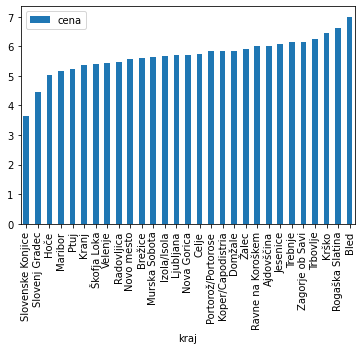

In [2]:
tabela.groupby('kraj').mean().sort_values('cena').plot.bar()

Iz diagrama je razvidno, da je najvišja povprečna cena za obrok na Bledu, najnižja pa v Slovenskih Konjicah.

Najprej sem preverila, ali velikost ponudbe v določenem kraju vpliva na povprečno ceno obroka.

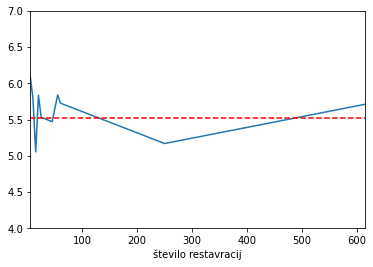

In [3]:
povprecna_cena = tabela.groupby('kraj').describe().cena[['count', 'mean']].rename(
    columns={'count':'število restavracij', 'mean': 'povprečje'}
)

povprecna_cena['število restavracij'] = povprecna_cena['število restavracij'].apply(int)
povprecna_cena['število restavracij'] = ((povprecna_cena['število restavracij'] // 5 + 1) * 5).apply(int)

max_cena = restavracije.groupby('kraj').mean().cena.max().round()
min_cena = restavracije.groupby('kraj').mean().cena.min().round()
povp_cena = restavracije.cena.mean()



povprecna_cena.groupby('število restavracij').mean().povprečje.plot(ylim=(min_cena,max_cena)).axhline(
    color='red', y=povp_cena, linestyle='--')

Kraje sem razdelila v skupine po velikosti ponudbe glede na pet restavracij (npr. "Kraji, ki imajo do 5 (10, 15, ...) restavracij") in nato pogledala povprečno ceno obroka v posamezni skupini. Kot vidimo, velikost ponudbe ne vpliva kaj dosti na samo ceno obroka. Cene se v vseh skupinah gibljejo blizu povprečne cene obroka v vseh restavracijah na srani (rdeča črta).

Nadalnje me je zanimalo, ali so cene obrokov povezane s turistično privlačnostjo kraja.

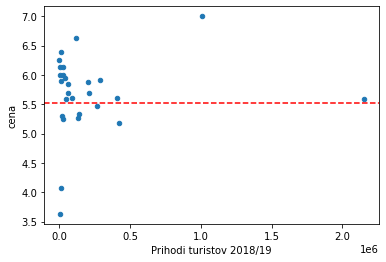

In [4]:
restavracije_turizem = pd.merge(restavracije, turizem, left_on='kraj', right_on='OBČINE')[
    ['ime', 'kraj', 'Prihodi turistov 2018/19', 'cena']
].dropna()
restavracije_turizem['Prihodi turistov 2018/19'] = restavracije_turizem['Prihodi turistov 2018/19'].apply(int)

restavracije_turizem.groupby('kraj').mean().plot(x='Prihodi turistov 2018/19', y='cena', kind='scatter').axhline(
   color='red', y=povp_cena, linestyle='--')

S pomočjo statistike za leti 2018 in 2019 sem preverila, ali skupno število prihodov turistov v določen kraj vpliva na ceno obroka. Upoštevati moramo, da sem nadaljnje primerjala le kraje, za katere imajo na [SiStat](https://pxweb.stat.si/SiStat) podatke. S tem nekateri zelo neobiskani kraji odpadejo. Med kraji, za katere imamo podatke, turistična privlačnost nima velikega vpliva. Opazimo lahko le, da v bolj obiskanih krajih cene niso izjemno nizke.

## Cena obroka in dodatne lastnosti restavracije

Restavracije na spletni strani [Študentska prehrana](https://www.studentska-prehrana.si/sl/restaurant) imajo določene dodatne lastnosti, kot so ponudba vegetarijanskih obrokov, dostop za invalide, dostava ... Zanimalo me je, ali število teh lastnosti vpliva na ceno obroka v restavraciji. Kaj pa kake specifične lastnosti restavracije?

In [5]:
stevilo_lastnosti = tabela.groupby('ime').describe().cena[['count', 'mean']].rename(
    columns={'count': 'število lastnosti', 'mean': 'cena'})

stevilo_lastnosti['število lastnosti'] = stevilo_lastnosti['število lastnosti'].apply(int)

stevilo_lastnosti = stevilo_lastnosti.groupby(
    'število lastnosti').describe().cena[
    ['count', 'mean']
].rename(columns={'count': 'število restavracij', 'mean': 'cena'})

stevilo_lastnosti['število restavracij'] = stevilo_lastnosti['število restavracij'].apply(int)

In [6]:
stevilo_lastnosti

,število restavracij,cena
število lastnosti,,
1,11,3.888182
2,74,5.250946
3,157,5.646752
4,83,5.592048
5,51,5.720784
6,8,5.402500
7,1,6.015714
8,1,5.300000


<AxesSubplot:xlabel='število lastnosti'>

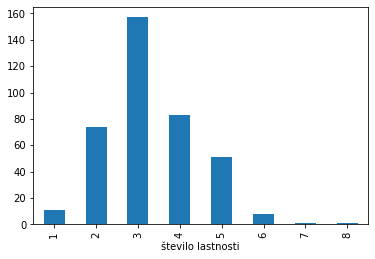

In [7]:
stevilo_lastnosti['število restavracij'].plot.bar()

Največ restavracij ima po tri dodatne lastnosti, le malo pa jih ima po eno ali šest. Na celotni strani sta le dve restavraciji, ki imata sedem ali osem restavracij.

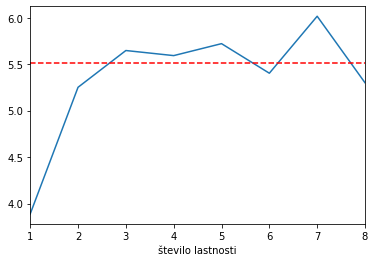

In [8]:
stevilo_lastnosti['cena'].plot().axhline(
   color='red', y=povp_cena, linestyle='--')

Vidimo lahko, da število dodatnih lastnosti, ki jih ima določena restavracija, vpliva na ceno obroka, vendar še zdaleč ne linearno. Cena obroka v restavracijah, ki imajo le eno dodatno lastnost, je občutno nižja, kot drugje. Tudi restavracije z dvema dodatnima lastnostima imajo v povprečju cenejše obroke, medtem ko so restavracije s tremi, štirimi in petimi lastnostmi cenovno nad povprečjem. Zaradi majhnosti skupin restavracij za sedem in osem lastnosti, iz podatkov za njih lahko sklepamo bolj malo.

Poglejmo si še, kako so posamezne lastnosti povezane s ceno obrokov.

In [9]:
data = {last: (tabela[tabela.lastnost == last].cena.mean()) for last in tabela.lastnost}
indeksi = [last for last in data]
cena_lastnosti = pd.DataFrame(list(data.items()), index=indeksi).drop(columns=0).rename(
    columns={1: 'povprečna cena'}
).sort_values('povprečna cena')

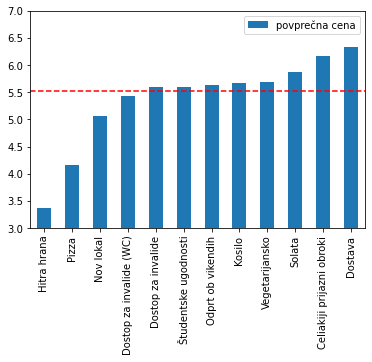

In [10]:
cena_lastnosti.plot.bar(ylim=(3,max_cena)).axhline(
   color='red', y=povp_cena, linestyle='--')

Restavracije, ki ponujajo hitro hrano in pice so precej cenejše, kot povprečje. Prav tako imajo tudi novi lokali nižje cene. Najdražje so restavracije, ki ponujajo celiakiji prijazne obroke ali dostavo. Med ostalimi lastnostmi ni velikih razlik.

## Dodatne lastnosti in lokacija

Nazdanje me je zanimalo, ali lokacija restavracije vpliva na število dodatnih lastnosti. Ali morda restavracije v Ljubljani ponujajo več stvari, kot kje drugje?

<AxesSubplot:>

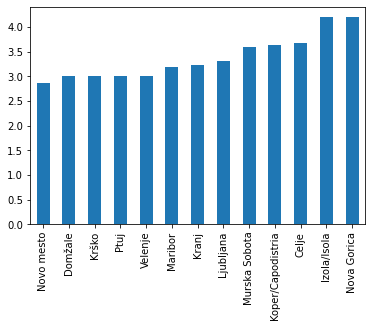

In [11]:
st_lastnosti_v_kraju = tabela.groupby('kraj').size()
st_restavracij_v_kraju = restavracije.groupby('kraj').size()
kraji_nad_5 = st_restavracij_v_kraju[st_restavracij_v_kraju >= 5]

lastnost_lokacija = pd.concat([st_lastnosti_v_kraju, kraji_nad_5], axis=1, sort=True).rename(
    columns={0: 'število lastnosti', 1: 'število restavracij'}).dropna()

lastnost_lokacija['povprečno število lastnosti restavracije'] = (
    lastnost_lokacija['število lastnosti'] / lastnost_lokacija['število restavracij'])

lastnost_lokacija['povprečno število lastnosti restavracije'].sort_values().plot.bar()

Zaradi boljše reprezentativnosti podatkov sem opazovala le kraje z vsaj petimi restavracijami. Opazimo lahko, da prestolnica ne izstopa, torej da ljubljanske restavracije v povprečju nimajo veliko več dodatnih lastnosti, kot kje drugje. Vidimo pa lahko, da so vsa primorska mesta na desnem robu diagrama, torej da imajo restavracije na Primorskem več dodatnih lastnosti.

Ali je število lastnosti, ki jih restavracija ponuja, povezano s turistično obiskanostjo kraja, v katerem se nahaja?

<AxesSubplot:xlabel='Prihodi turistov 2018/19', ylabel='povprečno število lastnosti'>

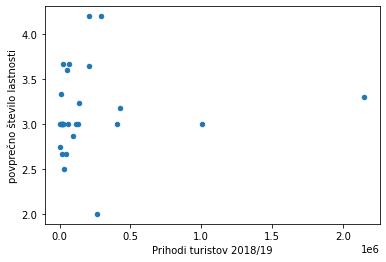

In [12]:
turizem_okrnjen = turizem.drop(columns={'Prihodi turistov 2018', 'Prihodi turistov 2019'}).dropna()
turizem_okrnjen['Prihodi turistov 2018/19'] = turizem_okrnjen['Prihodi turistov 2018/19'].apply(int)

stevilo_lastnosti= st_lastnosti_v_kraju.to_frame().reset_index().rename(columns={0: 'število lastnosti'})
stevilo_restavracij = st_restavracij_v_kraju.to_frame().reset_index().rename(columns={0: 'število restavracij'})

st_rest_last = pd.merge(stevilo_lastnosti, stevilo_restavracij)
st_rest_last['povprečno število lastnosti'] = st_rest_last['število lastnosti'] / st_rest_last['število restavracij']
st_rest_last = st_rest_last.drop(columns={'število lastnosti', 'število restavracij'})

tur_rest_last = pd.merge(st_rest_last, turizem_okrnjen, left_on='kraj', right_on='OBČINE').drop(columns={'OBČINE'})

tur_rest_last.plot(x='Prihodi turistov 2018/19', y='povprečno število lastnosti', kind='scatter')

Vidimo lahko, da povprečno število dodatnih lastnosti ni odvisno od turističnosti kraja, v katerem se restavracija nahaja. 

Nazadnje me je zanimalo še, ali so določene lastnosti v bolj turističnih krajih bolj pogoste. Pogledala sem povprečno kako pogosto se neka lastnost pojavi v kraju z do 50 000, 100 000, itd. obiskovalci.

<AxesSubplot:xlabel='turisti po 50 000'>

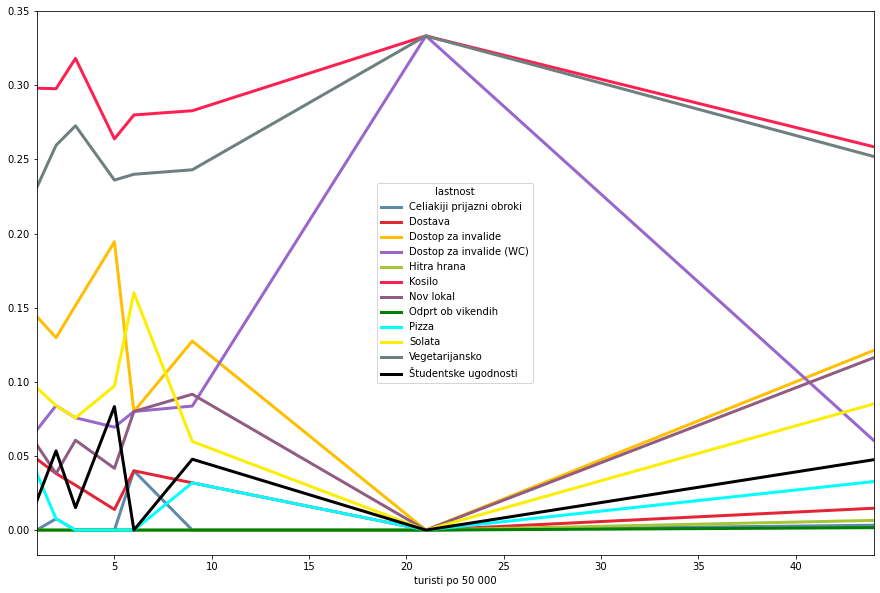

In [135]:
lastnosti_turizem = pd.merge(tabela, turizem_okrnjen, left_on='kraj', right_on='OBČINE').drop(columns={'OBČINE'})
lastnosti_turizem['turisti po 50 000'] = lastnosti_turizem['Prihodi turistov 2018/19'] // 50000 + 1
l_t = lastnosti_turizem.groupby(['turisti po 50 000', 'lastnost']).describe()[
    'Prihodi turistov 2018/19'].rename(columns={'count': 'število'})
l_t['delež'] = l_t['število'] / lastnosti_turizem.groupby('turisti po 50 000').count().lastnost
l_t.delež.unstack(level=1).fillna(0).plot(figsize=(15, 10), color = [
    '#5d8aa8', '#e32636', '#ffbf00', '#9966cc', '#a4c639', '#ff2052', 
'#915c83', '#008000', '#00ffff', '#fdee00', '#6e7f80', '#000000'], lw=3)

Vidimo, da ponudba kosil prevladuje povsod, ne glede na obiskanost kraja, podobno tudi možnost vegetarijanskih obrokov. Prav tako opazimo, da se označba ponudbe hitre hrane pojavi šele v turistično zelo obiskanih krajih, delež, ki ga predstavlja dostava, pa je tam nekoliko manjši.
Žal se nam del grafa med 20- in 25-krat po 50 000 turistov ne pove veliko, saj v to skupino pade le Bled z eno samo restavracijo s študentsko prehrano.

## Zaključek

Z analizo podatkov s spletne strani [Študentska prehrana](https://www.studentska-prehrana.si/sl/restaurant) sem večino svojih hipotez ovrgla.
Korelacijo sem zasledila predvsem med ceno obroka v restavraciji in lastnostmi, ki jih le ta ponuja. Hitra hrana in pice so v povprečju cenejše, v restavracijah, kjer ponujajo celiakiji prijazne obroke ali dostavo, pa so cene študentskega obroka najvišje. Sama lokacija restavracije ali turistična obiskanost kraja, v katerem se restavracija nahaja, tako na ceno kot na lastnosti, ki jih restavracija ponuja, nima velikega vpliva.